In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
chips_data = pd.read_csv("chips.csv", header=None)[1:]
chips_X = np.array(chips_data.loc[:, 0:1], dtype=np.float)
chips_y = np.where(chips_data.loc[:, 2] == 'P', 1, -1).astype(np.int8)

In [3]:
geyser_data = pd.read_csv("geyser.csv", header=None)[1:]
geyser_X = np.array(geyser_data.loc[:, 0:1], dtype=np.float)
geyser_y = np.where(geyser_data.loc[:, 2] == 'P', 1, -1).astype(np.int8)

In [4]:
class SVM:
    X_train = None
    y_train = None
    X_test = None
    y_test = None

    def __init__(self, kernel_name='linear', C=1, degree=2, ksi=1, tolerance=1e-3, verbose=False, verbose_i=1000,
            max_iter=np.inf):
        self.C = C
        self.tolerance = tolerance
        self.kernel_name = kernel_name
        self.verbose = verbose
        self.verbose_i = verbose_i
        self.max_iter = max_iter

        def gaussian(a, b):
            if b.ndim == 1:
                return np.exp(-ksi * (a - b[None])**2).sum(axis=1)
            return np.exp(-ksi * (a - b)**2).sum(axis=1)

        kernels = {
            'linear': lambda a, b: a @ b.T,
            'polynomial': lambda a, b: (a @ b.T + 1)**degree,
            'gaussian': gaussian,
        }
        self.K = kernels[kernel_name]


    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float)
        self.y_train = np.array(y)
        self.N_train = self.X_train.shape[0]
        self.k_train = self.X_train.shape[1]
        self.alpha = np.random.sample(self.N_train)*self.C
        self.bias = np.random.random()
        self.error_cache = self.__error__(self.X_train, self.y_train)

        is_changed = False
        should_examine_all = True
        i = 0
        while (is_changed or should_examine_all) and i < self.max_iter:
            i+=1
            if self.verbose and i % self.verbose_i == 0:
                self.visualize(self.X_train, self.y_train)

            if should_examine_all:
                is_changed = self.__train__(np.arange(self.N_train))
            else:
                indexes_to_examine = np.where(
                    np.all(
                        (self.alpha != 0, self.alpha != self.C),
                        axis=0
                    )
                )[0]
                is_changed = self.__train__(indexes_to_examine)

            if should_examine_all:
                should_examine_all = False
            elif not is_changed:
                should_examine_all = True

    def predict_margin(self, X):
        # if self.kernel_name == 'linear':
        #     return self.w @ X.T - self.bias
        if self.kernel_name in ['linear', 'polynomial']:
            return (self.y_train * self.alpha * self.K(X, self.X_train)).sum(axis=1) - self.bias
        return (self.y_train * self.alpha * np.apply_along_axis(self.K, 1 , X, self.X_train)).sum(axis=1) - self.bias

    def predict(self, X):
        return np.sign(self.predict_margin(X))


    def __train__(self, indexes2):
        X2 = self.X_train[indexes2]
        y2 = self.y_train[indexes2]
        alpha2 = self.alpha[indexes2]
        err2 = self.error_cache[indexes2]
        r2 = err2 * y2
        i2_for_step = np.where(np.any(
            (
                np.all((r2 < -self.tolerance, alpha2 < self.C), axis=0),
                np.all((r2  > self.tolerance, alpha2 > 0), axis=0)
            ),
            axis=0
        ))[0]

        for i2 in i2_for_step:
            if len(np.all((self.alpha != self.C, self.alpha != 0), axis=0)) > 1:
                i1 = np.argmax(np.abs(self.error_cache - err2[i2]))
                if self.step(i1=i1, i2=i2): return True

            i1_for_step = np.where(np.all((self.alpha != self.C, self.alpha != 0), axis=0))[0]
            rand_start = np.random.randint(i1_for_step.shape[0])
            for i1 in np.concatenate((i1_for_step[rand_start:], i1_for_step[:rand_start])):
                if self.step(i1=i1, i2=i2): return True

            i1_for_step = np.arange(self.N_train)
            rand_start = np.random.randint(i1_for_step.shape[0])
            for i1 in np.concatenate((i1_for_step[rand_start:], i1_for_step[:rand_start])):
                if self.step(i1=i1, i2=i2): return True
        return False


    def step(self, i1, i2):

        if i1 == i2: return False

        alpha1 = +self.alpha[i1]
        y1 = self.y_train[i1]
        X1 = self.X_train[i1]
        err1 = self.error_cache[i1]
        X2 = self.X_train[i2]
        y2 = self.y_train[i2]
        alpha2 = +self.alpha[i2]
        err2 = self.error_cache[i2]
        s = y1*y2
        L = max(0, alpha1 + alpha2 - self.C) if y1 == y2 else max(0, alpha2 - alpha1)
        H = min(self.C, alpha1 + alpha2) if y1 == y2 else min(self.C, self.C + alpha2 - alpha1)
        if L == H: return False

        k11 = self.K(X1, X1)
        k12 = self.K(X1, X2)
        k22 = self.K(X2, X2)
        eta = k11+k22-2*k12

        if eta > 0:
            a2 = alpha2 + y2*(err1-err2)/eta
            if a2 < L: a2 = L
            elif a2 > H: a2 = H
        else:
            f1 = y1 * (err1 + self.bias) - alpha1 * k11 - s * alpha2 * k12
            f2 = y2 * (err2 + self.bias) - s *  alpha1 * k12 - alpha2 * k22
            L1 = alpha1 + s * (alpha2 - L)
            H1 = alpha1 + s * (alpha2 - H)
            Lobj = L1*f1 + L*f2 + .5*L1**2*k11 + .5*L**2*k22 + s*L*L1*k12
            Hobj = H1*f1 + H*f2 + .5*H1**2*k11 + .5*H**2*k22 + s*H*H1*k12
            if Lobj < Hobj:
               a2 = L
            elif Lobj > Hobj:
               a2 = H
            else:
               a2 = alpha2
        if np.allclose(a2, alpha2): return False
        # if np.abs(a2-alpha2) < np.finfo(float).eps*(a2+alpha2+np.finfo(float).eps): return False

        a1 = alpha1 + s*(alpha2-a2)
        b1 = err1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self.bias
        b2 = err2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self.bias
        self.bias = (b2 + b1)/2
        # self.w = (self.y_train * self.alpha * self.X_train.T).sum(axis=1)
        self.error_cache = self.__error__(self.X_train, self.y_train)
        self.alpha[i1] = +a1
        self.alpha[i2] = +a2
        return True


    def __error__(self, X, y):
        return self.predict(X) - y


    def visualize(self, X=None, y=None):
        if X is None:
            if self.X_test is None:
                X = self.X_train
            else: X = self.X_test
        if y is None:
            if self.y_test is None:
                y = self.y_train
            else: y = self.y_test
        xx, yy = np.meshgrid(np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000), np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000))
        pred = self.predict(np.c_[xx.ravel(), yy.ravel()])
        pred = pred.reshape(xx.shape)

        plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))

        plt.scatter(X[:,0], X[:,1], c=y)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.show()



In [5]:
with open('linear_geyser_top.txt', 'w') as top_file:
    tmp_top = []
    for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
        svm = SVM(C=C)
        svm.fit(geyser_X, geyser_y)
        tmp_top.append([np.abs(svm.__error__(geyser_X, geyser_y)).sum(), C])
        # svm.visualize()
    tmp_top.sort(key=lambda a: a[0])
    top_file.write(np.array2string(np.array(tmp_top)))

KeyboardInterrupt: 

In [ ]:
with open('polynomial_geyser_top.txt', 'w') as top_file:
    tmp_top = []
    for i in range(1, 7):
        for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
            svm = SVM(kernel_name='polynomial', degree=i, C=C)
            svm.fit(geyser_X, geyser_y)
            tmp_top.append([np.abs(svm.__error__(geyser_X, geyser_y)).sum(), C, i])
            # svm.visualize()
    tmp_top.sort(key=lambda a: a[0])
    top_file.write(np.array2string(np.array(tmp_top)))

In [ ]:
with open('gaussian_geyser_top.txt', 'w') as top_file:
    tmp_top = []
    for i in range(1, 7):
        for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
            svm = SVM(kernel_name='gaussian', ksi=i, C=C)
            svm.fit(geyser_X, geyser_y)
            tmp_top.append([np.abs(svm.__error__(geyser_X, geyser_y)).sum(), C, i])
            # svm.visualize()
    tmp_top.sort(key=lambda a: a[0])
    top_file.write(np.array2string(np.array(tmp_top)))

In [ ]:
with open('linear_chips_top.txt', 'w') as top_file:
    tmp_top = []
    for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
        svm = SVM(C=C)
        svm.fit(chips_X, chips_y)
        tmp_top.append([np.abs(svm.__error__(chips_X, chips_y)).sum(), C])
        # svm.visualize()
    tmp_top.sort(key=lambda a: a[0])
    top_file.write(np.array2string(np.array(tmp_top)))

In [ ]:
with open('polynomial_chips_top.txt', 'w') as top_file:
    tmp_top = []
    for i in range(1, 7):
        for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
            svm = SVM(kernel_name='polynomial', degree=i, C=C)
            svm.fit(chips_X, chips_y)
            tmp_top.append([np.abs(svm.__error__(chips_X, chips_y)).sum(), C, i])
            # svm.visualize()
    tmp_top.sort(key=lambda a: a[0])
    top_file.write(np.array2string(np.array(tmp_top)))

In [ ]:
with open('gaussian_chips_top.txt', 'w') as top_file:
    tmp_top = []
    for i in np.arange(1, 7):
        for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
            svm = SVM(kernel_name='gaussian', ksi=i, C=C)
            svm.fit(chips_X, chips_y)
            tmp_top.append([np.abs(svm.__error__(chips_X, chips_y)).sum(), C, i])
            # svm.visualize()
    tmp_top.sort(key=lambda a: a[0])
    top_file.write(np.array2string(np.array(tmp_top)))


<ipython-input-4-eeeef948fc82>:174: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))


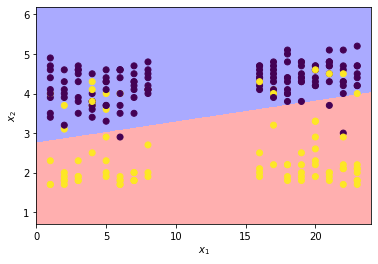

Accuracy: 0.90


In [6]:
svm = SVM(C=0.1)
svm.fit(geyser_X, geyser_y)
svm.visualize()
print('Accuracy: %0.2f' % (1 - .5 * np.abs(svm.__error__(geyser_X, geyser_y)).sum()/svm.N_train))

In [7]:
svm = SVM(kernel_name='polynomial', C=0.1, degree=1)
svm.fit(geyser_X, geyser_y)
svm.visualize()
print('Accuracy: %0.2f' % (1 - .5 * np.abs(svm.__error__(geyser_X, geyser_y)).sum()/svm.N_train))

KeyboardInterrupt: 

In [ ]:
svm = SVM(kernel_name='gaussian', C=10, ksi=1)
svm.fit(geyser_X, geyser_y)
svm.visualize()
print('Accuracy: %0.2f' % (1 - .5 * np.abs(svm.__error__(geyser_X, geyser_y)).sum()/svm.N_train))

In [ ]:
svm = SVM(C=10)
svm.fit(chips_X, chips_y)
svm.visualize()
print('Accuracy: %0.2f' % (1 - .5 * np.abs(svm.__error__(chips_X, chips_y)).sum()/svm.N_train))

In [ ]:
svm = SVM(kernel_name='polynomial', C=100, degree=2)
svm.fit(chips_X, chips_y)
svm.visualize()
print('Accuracy: %0.2f' % (1 - .5 * np.abs(svm.__error__(chips_X, chips_y)).sum()/svm.N_train))

In [ ]:
svm = SVM(kernel_name='gaussian', C=50, ksi=6)
svm.fit(chips_X, chips_y)
svm.visualize()
print('Accuracy: %0.2f' % (1 - .5 *np.abs(svm.__error__(chips_X, chips_y)).sum()/svm.N_train))
